# Plot feature permutation importance (FPI) results

This notebook will visualize/consolidate the FPI results of the machine learning runs (organized in different branches) in this repositiory.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the repository url to work with and prefix for where it will be copied.
repo_prefix = './'

org='parallelworks'
repo_name='dynamic-learning-rivers'
repo_url = 'https://github.com/'+org+'/'+repo_name

Matplotlib is building the font cache; this may take a moment.


## Grab data

Since the ML runs are on different branches, we need to jump from branch-to-branch and gather and plot data along the way.

On first branch; clone, checkout, and build feature integer ID lookup table...
fatal: destination path 'dynamic-learning-rivers' already exists and is not an empty directory.
Checking out files: 100% (356/356), done.
Switched to branch 'Nov-2023-log10'
Significant features for the ML model on this branch:
1 --- run_mm_cyr
2 --- pre_mm_cyr
3 --- pre_mm_cdi
4 --- tmp_dc_cdi
5 --- RA_SO
6 --- RA_dm
7 --- RA_ms_av
8 --- RA_ms_di
9 --- crp_pc_cse
10 --- ire_pc_cse
11 --- for_pc_cse
12 --- slp_dg_cav
13 --- gwt_cm_cav
14 --- ele_mt_cav
15 --- tmp_dc_cyr
16 --- Mean_Temp_Deg_C
17 --- Mean_DO_mg_per_L
18 --- Mean_DO_percent_saturation
19 --- pst_pc_cse
20 --- ppd_pk_cav
21 --- dor_pc_pva
22 --- pH
23 --- sgr_dk_rav
24 --- prm_pc_cse
Checking out files: 100% (356/356), done.
Branch Oct-2023-log10 set up to track remote branch Oct-2023-log10 from origin.
Switched to a new branch 'Oct-2023-log10'
Significant features for the ML model on this branch:
1 --- run_mm_cyr
2 --- pre_mm_cyr
3 --- pre_mm_

Text(0, 0.5, 'FPI importance ratio (no unit)')

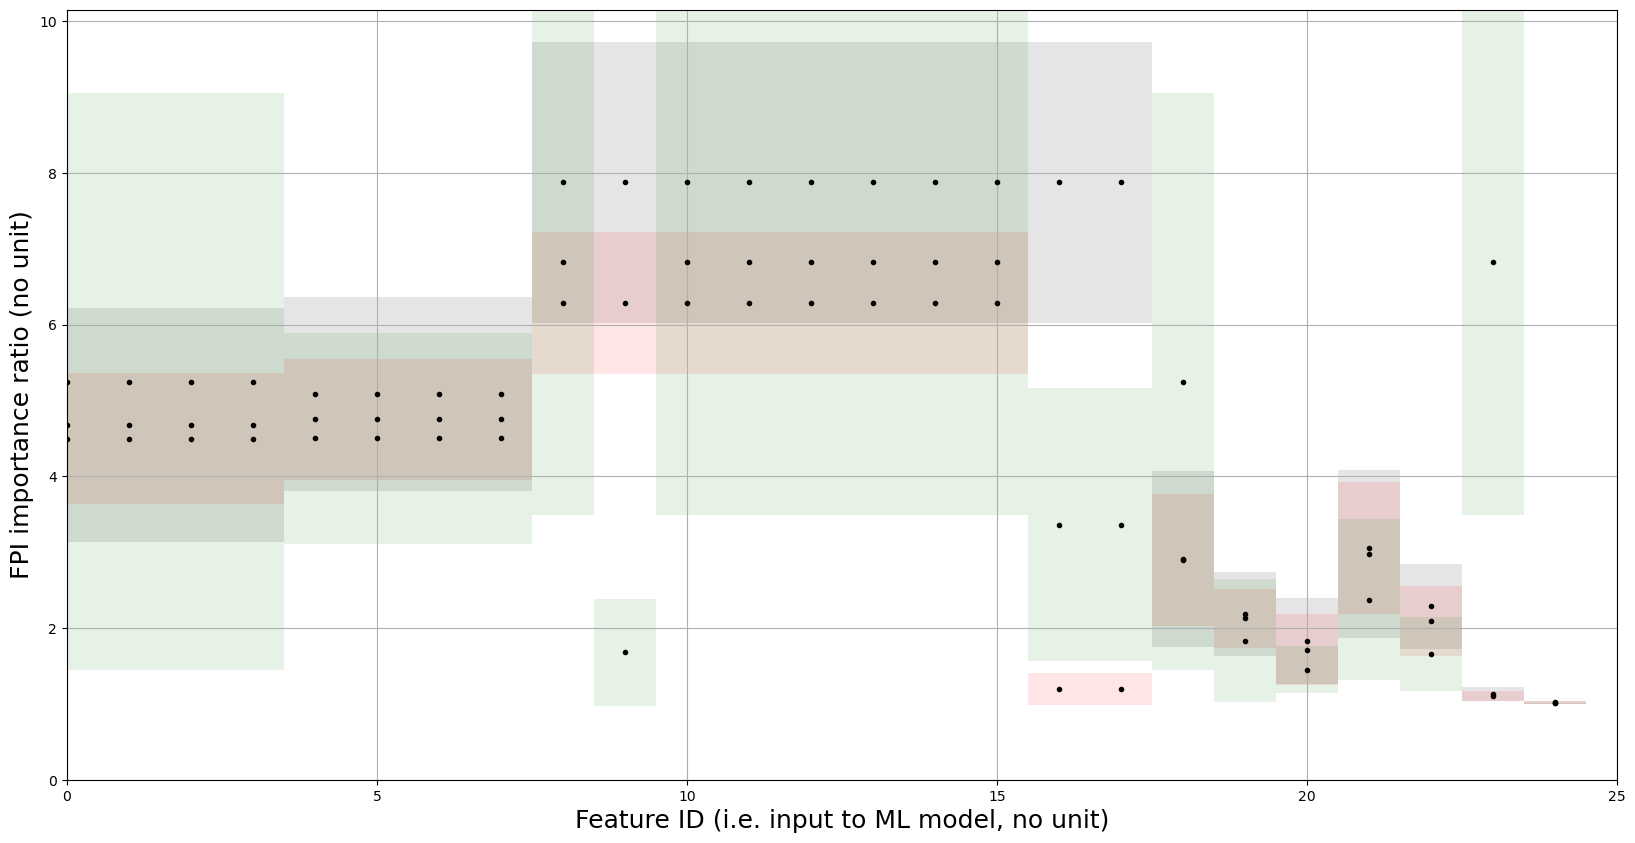

In [7]:
# Make a list of which branches to operate on.
# ASSUME that the first branch will have the most
# complete list of features (i.e. inputs) to the ML
# models. This first list of features will be
# used to create a look-up table for feature-to-feature
# comparisons/visulizations later.

list_branches = ['Nov-2023-log10', 'Oct-2023-log10', 'Nov-2022-log10']
list_colors = ['k','r','g','b']
fpi_max = 0.0

# Initialize empty dataframes
# for model scores and histograms
model_scores = pd.DataFrame(columns=['hold-out-avg','hold-out-std','ntrain'])
train_hist = pd.DataFrame(columns=list_branches)
predict_hist = pd.DataFrame(columns=list_branches)

# Initialize a plot
fig, ax = plt.subplots(1,1,figsize=(20,10))

for ll,branch in enumerate(list_branches):
    
    # Check for first branch
    if ll == 0:
        print("On first branch; clone, checkout, and build feature integer ID lookup table...")
        ! mkdir -p {repo_prefix}
        ! cd {repo_prefix}; git clone {repo_url}
        ! cd {repo_prefix}/{repo_name}; git checkout {branch}
        
        # Load data for look up table only
        fpi_avg = pd.read_csv(repo_prefix+repo_name+'/output_data/fpi_avg.csv', index_col=False)
        
        # Make the loop up table; need to invert
        # the keys (integers) with the values (feature names)
        # so that feature names can be converted to ints
        # later.
        feature_id_name_dict = dict((v,k) for k,v in fpi_avg['Unnamed: 0'].to_dict().items())
        
        # Unload the data b/c later we will want to use the index
        del fpi_avg
    else:
        # Set up is complete with first branch, just change to other branches
        ! cd {repo_prefix}/{repo_name}; git checkout {branch}
    
    # Load data and replace feature names with IDs in dict
    # In the process, get a list of features available in
    # just this branch.
    fpi_avg = pd.read_csv(repo_prefix+repo_name+'/output_data/fpi_avg.csv', index_col=0)
    branch_feature_names = list(fpi_avg.index)
    fpi_avg.rename(index=feature_id_name_dict, inplace=True)
    
    fpi_std = pd.read_csv(repo_prefix+repo_name+'/output_data/fpi_std.csv', index_col=0)
    fpi_std.rename(index=feature_id_name_dict, inplace=True)
    
    # Get summary statistics over each FPI (random shuffle
    # of grouped features) iteration
    mean = fpi_avg.mean(axis=1)
    upper = fpi_avg.mean(axis=1)+fpi_avg.std(axis=1)
    lower = fpi_avg.mean(axis=1)-fpi_avg.std(axis=1)
    error = fpi_std.max(axis=1)
    
    # If the max value is bigger than the current value,
    # update it.
    if upper.max() > fpi_max:
        fpi_max = upper.max()
        
    # Start printing out good features:
    print('Significant features for the ML model on this branch:')
    ff = 1
    
    # Plot a box for each feature. We work feature by feature
    # because not all features will be available and not all
    # are chopped out from the edges either; sometimes features
    # will be chopped out from the middle so we don't want to
    # plot continuous lines.
    for feature in branch_feature_names:
        # Get feature ID from the dict
        f_id = feature_id_name_dict[feature]
        
        # Get the center of the box
        f_mean = mean[f_id]
        
        # Get the upper and lower bounds of the box
        f_upper = upper[f_id] 
        f_lower = lower[f_id]
        f_error = error[f_id]
        
        left, bottom, width, height = (f_id - 0.5, f_lower, 1.0, f_upper-f_lower)
        #print(left)
        #print(bottom)
        #print(width)
        #print(height)
        
        rect = plt.Rectangle((left, bottom), width, height,
            facecolor=list_colors[ll], alpha=0.1)
        
        # Add collection to axes
        ax.add_patch(rect)
        
        # Plot means
        ax.plot(f_id,f_mean,'k.')
        
        # Print out feature name if it is a significant contribution
        # (Here, assume that "significant" means the lowest bound on
        # the FPI improvement ratio is above 1.0)
        if f_lower > 1.0:
            print(str(ff)+" --- "+feature)
            ff = ff + 1
            
    # Clear loaded data
    del fpi_std
    del fpi_avg
    
    # Load model scores
    # This file summarizes the holdout score for all the
    # Superlearners for each ICON-ModEx iteration.
    holdout_score = pd.read_csv(
        repo_prefix+repo_name+'/output_data/holdout_score.txt', 
        sep=':', 
        names=['Value','Number'], 
        index_col='Value' )
    
    # This file lists the total number of data available
    # (of which 25% is split to the testing set)
    input_data = pd.read_csv(repo_prefix+repo_name+'/input_data/ICON-ModEx_Data.csv')
    
    model_scores.loc[len(model_scores.index)] = [
        holdout_score.loc['Avg',:].values[0],
        holdout_score.loc['Std',:].values[0],
        len(input_data.index)
    ]
    
    # Grab histograms of the distribution of the target to
    # assess bias in the ML models
    train_all = pd.read_csv(repo_prefix+repo_name+'/input_data/ICON-ModEx_Data.csv')
    train_hist[branch] = train_all['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment']
    predict_all = pd.read_csv(repo_prefix+repo_name+'/output_data/filtered_predict_output.csv')
    predict_hist[branch] = predict_all['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment']
    
# Done with looping over branches
ax.grid()

plt.xlim(0,len(feature_id_name_dict))
plt.ylim(0,fpi_max)

plt.xlabel('Feature ID (i.e. input to ML model, no unit)', fontsize=18)
plt.ylabel('FPI importance ratio (no unit)', fontsize=18)

In [ ]:
# Set up side-by-side plot
fig, (ax0, ax1)  = plt.subplots(1,2,figsize=(20,5))

# Plot progression of model score with training attempt
ax0.errorbar(model_scores.index, model_scores['hold-out-avg'],yerr=model_scores['hold-out-std'], fmt='ko')
ax0.grid()
ax0.set_xlabel('Run ID', fontsize=18)
ax0.set_ylabel('ML model score (R^2)', fontsize=18)

# Plot progression of histograms (for bias) with training attempt
nbin = 25
for bb,branch in enumerate(list_branches):
    # Histogram for training set truth reference
    n, bins, patches = ax1.hist(
            np.log10(np.abs(train_hist[branch])),
            nbin, density=True, histtype="stepfilled", linestyle=('dashed'), color=('gray'), alpha=0.5)
    
    # Histogram for predictions
    n, bins, patches = ax1.hist(
            np.log10(np.abs(predict_hist[branch])),
            nbin, density=True, histtype="step", linestyle=('solid'), color=(list_colors[bb]), linewidth=3)
    
ax1.grid()
ax1.set_ylabel('Frequency (counts)', fontsize=18)
ax1.set_xlabel('Log10 of respiration rate (log10(mg O2/L/hr))', fontsize=18)

In [ ]:
feature_id_name_dict